In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils
import torch.autograd as autograd

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Hyperparameters**

In [45]:
# Please use the model trained w/o BN (batch normalization), otherwise we will have bug in inference...
# _tanh.pth: nn.Tanh() as activation
# other.pth: LeakyReLU as activation
class Para():
    def __init__(self):
        self.latent_dim = 2 # latent space dimention
        self.img_shape = (1, 28, 28) # image shape (1x28x28 for MNIST)
        self.generator_path = 'G_l2_woBN.pth' # pre-trained generator path
        self.discriminator_path = 'D_l2_woBN.pth' # pre-trained discriminator path
        self.batch_size = 25 # batch size for visualization
        self.gd_size = 21
        
opt = Para()

**Network architectures**

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # layers.append(nn.Tanh())
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

**Load networks**

In [47]:
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))

<All keys matched successfully>

**Generator and discriminator visualization**

In [48]:
def vis(y, nrow, title='figure', figsize=(4, 4)):
    imgs = torchvision.utils.make_grid(y, nrow=nrow, padding=0, normalize=True)

    plt.figure(figsize=figsize)
    if cuda:
        plt.imshow(imgs.permute(1, 2, 0).cpu())
    else:
        plt.imshow(imgs.permute(1, 2, 0))
    plt.title(title)
    plt.show()   

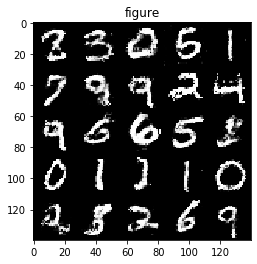

In [49]:
# z = Variable(torch.from_numpy(np.float32(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))) # latend variables
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))

with torch.no_grad():
    generated_imgs = generator(z) # generate images
    validity = discriminator(generated_imgs) # discriminator validaty

vis(generated_imgs, nrow=int(np.sqrt(opt.batch_size)))

**GD**

$$\min_uJ(u)=\frac{1}{2}\|G(u)-y\|_2^2$$
$$u_{k+1}=u_k-\alpha_kDJ(u)$$

In [7]:
def GD(u_0, y, lr=5e-3, a=0, loss=nn.MSELoss(), index=0, m=0, noise=False, epoch=4000):
    # GD function for a single image! Index here means the index of the figure above.
    # Note that since we only care about a single image, the loss only contains single image loss.
    # If you want to solve for a batch of image, please use index like [0,1,2,3] or range(4)
    u_hat = u_0
    alpha = lr
    epoch = epoch
    U = np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
    U[0, :, :] = u_0.detach().cpu().numpy()

    L = []
    for i in range(epoch):
        if noise:
            l = loss(generator(u_hat)[index, :, :, :], y[index, :, :, :]) + a*loss(u_hat[index, :], m[index, :])
        else:
            l = loss(generator(u_hat)[index, :, :, :], y[index, :, :, :])
        
        L.append(l.item())
        if i % 500 == 0:
            print('['+str(i)+'/'+str(epoch)+']', l.item())
        
        if noise:
            grad = autograd.grad(outputs=loss(generator(u_hat)[index, :, :, :], y[index, :, :, :]) + a*loss(u_hat[index, :], m[index, :]), inputs=u_hat)[0]
        else:
            grad = autograd.grad(outputs=loss(generator(u_hat)[index, :, :, :], y[index, :, :, :]), inputs=u_hat)[0]
        
        u_hat = u_hat - alpha * grad
        U[1+i, :, :] = u_hat.detach().cpu().numpy()

    plt.plot(L)
    plt.title('GD loss curve')
    plt.show()
    
    return u_hat, U, l.item()

In [8]:
def heatmap(y, loss=nn.MSELoss(), index=0, u1_min=-2.5, u1_max=1.0, u2_min=-2.5, u2_max=0.5, noise=False, m=0, a=0):
    # Loss heatmap
    u1_length = 100 # int((u1_max-u1_min)*50) + 1
    u2_length = 100 # int((u2_max-u2_min)*50) + 1

    u1 = np.linspace(u1_min, u1_max, u1_length)
    u2 = np.linspace(u2_max, u2_min, u2_length)

    Loss = np.zeros((u1_length, u2_length))

    for i in range(u1_length):
        for j in range(u2_length):
            with torch.no_grad():
                temp = np.array([[u1[i], u2[j]], [u1[i], u2[j]]])
                if noise:
                    Loss[j, i] = (loss(generator(Tensor(temp))[0, :, :, :], y[index, :, :, :]) + a*loss(Tensor(temp)[0, :], m[index, :])).item()
                else:
                    Loss[j, i] = loss(generator(Tensor(temp))[0, :, :, :], y[index, :, :, :]).item()
    
    return u1, u2, Loss

In [318]:
opt.gd_size = 21
u_gt = Variable(Tensor(np.random.normal(0, 1, (opt.gd_size, opt.latent_dim)))) # ground truth u
with torch.no_grad():
    y = generator(u_gt) # generated y from u_gt

torch.Size([21, 2])
torch.Size([21, 1, 28, 28])


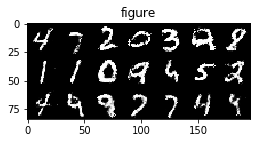

In [319]:
# Visualization of u_gt and y
print(u_gt.shape)
print(y.shape)
vis(y, nrow=7)

[0/40000] 0.5667902827262878
[500/40000] 0.5249148011207581
[1000/40000] 0.4987095892429352
[1500/40000] 0.4947721064090729
[2000/40000] 0.49191293120384216
[2500/40000] 0.48940765857696533
[3000/40000] 0.4883171617984772
[3500/40000] 0.4874606132507324
[4000/40000] 0.4869493842124939
[4500/40000] 0.4866257309913635
[5000/40000] 0.4863716959953308
[5500/40000] 0.48615866899490356
[6000/40000] 0.48593375086784363
[6500/40000] 0.4846196472644806
[7000/40000] 0.48450425267219543
[7500/40000] 0.48444488644599915
[8000/40000] 0.4843686521053314
[8500/40000] 0.4842633306980133
[9000/40000] 0.4842150807380676
[9500/40000] 0.4841679632663727
[10000/40000] 0.4841013550758362
[10500/40000] 0.48399847745895386
[11000/40000] 0.4839034378528595
[11500/40000] 0.4838487505912781
[12000/40000] 0.48381567001342773
[12500/40000] 0.4837912321090698
[13000/40000] 0.4837705194950104
[13500/40000] 0.4837518632411957
[14000/40000] 0.48373445868492126
[14500/40000] 0.48371779918670654
[15000/40000] 0.48370161

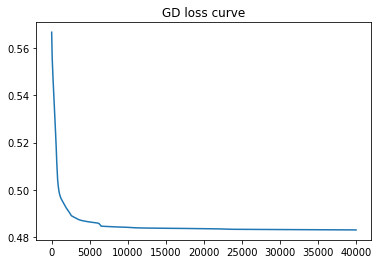

ValueError: too many values to unpack (expected 2)

In [304]:
index = range(21)
u_0 = Variable(Tensor(np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))), requires_grad=True)
u_hat, U = GD(y=y, u_0=u_0, index=index, epoch=40000)

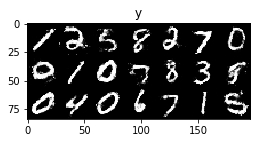

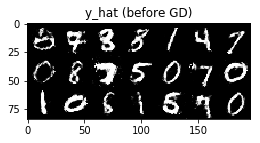

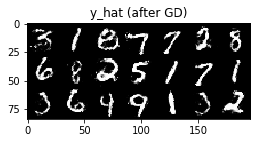

In [305]:
# Visualization of y_hat and y
vis(y[index, :, :, :], nrow=7, title='y')

with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0[index, :, :, :], nrow=7, title='y_hat (before GD)')
vis(y_hat[index, :, :, :], nrow=7, title='y_hat (after GD)')

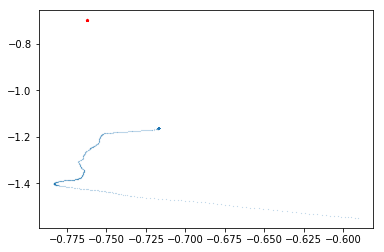

In [309]:
index = 5
plt.scatter(U[:, index, 0], U[:, index, 1], s=0.01)
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

In [310]:
u1, u2, Loss = heatmap(y, u1_min=-0.9, u1_max=-0.5, u2_min=-1.8, u2_max=-0.6, index=index)

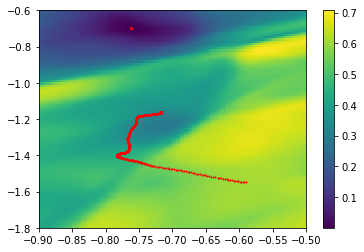

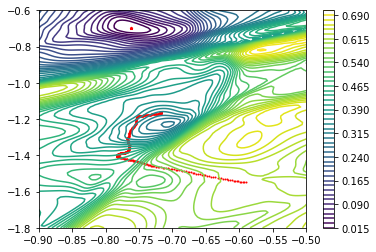

In [311]:
plt.pcolor(u1, u2, Loss)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

plt.contour(u1, u2, Loss, 50)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

**GD with random initial points**

[0/1000] 0.49047204852104187
[500/1000] 0.3434973359107971


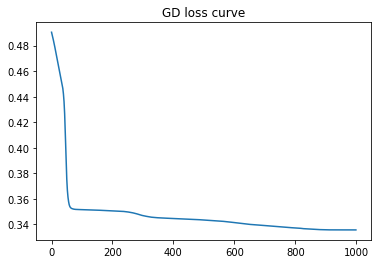

[0/1000] 0.6774383187294006
[500/1000] 0.3166634440422058


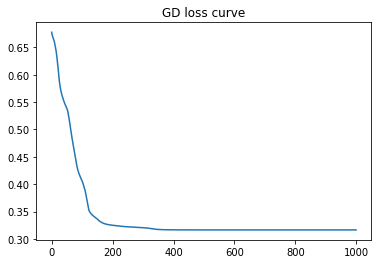

[0/1000] 0.5650053024291992
[500/1000] 0.37152963876724243


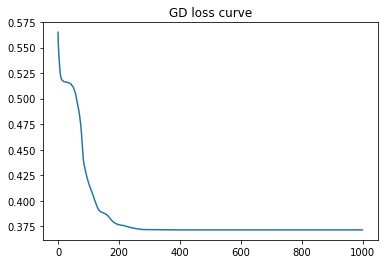

[0/1000] 0.4332652986049652
[500/1000] 0.35541895031929016


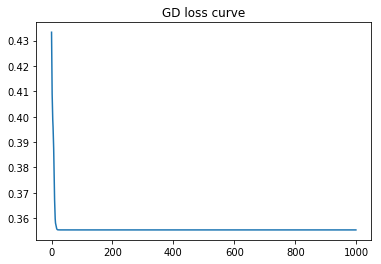

[0/1000] 0.8587789535522461
[500/1000] 0.5067886114120483


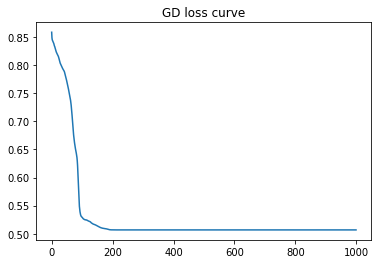

[0/1000] 0.5365089178085327
[500/1000] 0.3715292513370514


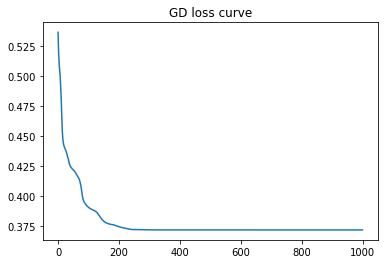

[0/1000] 0.48048487305641174
[500/1000] 0.46342262625694275


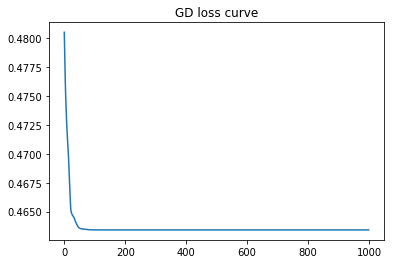

[0/1000] 0.6087395548820496
[500/1000] 0.3264293372631073


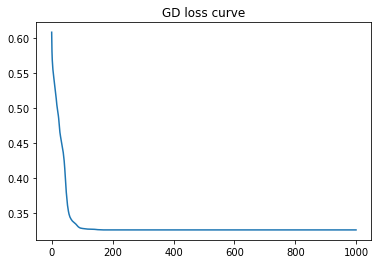

[0/1000] 0.516211211681366
[500/1000] 0.47328442335128784


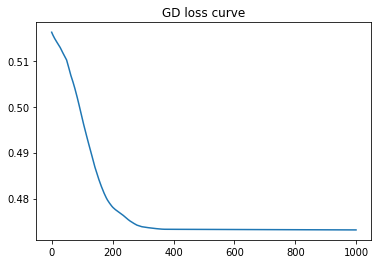

[0/1000] 0.5439541339874268
[500/1000] 0.39274725317955017


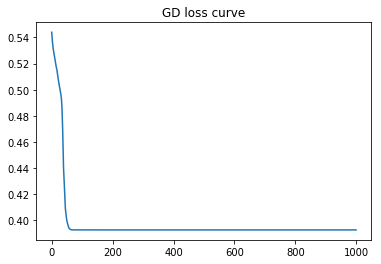

[0/1000] 0.6161513924598694
[500/1000] 0.40635696053504944


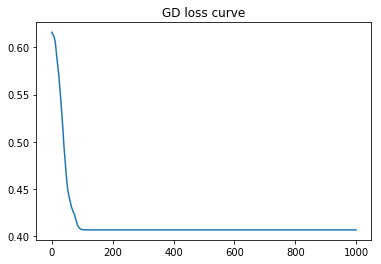

[0/1000] 0.5193365216255188
[500/1000] 0.5153746008872986


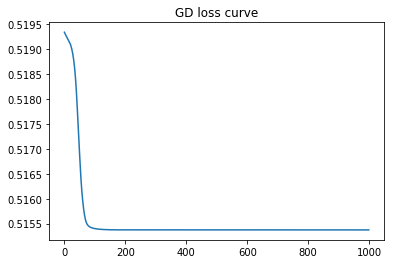

[0/1000] 0.1777505725622177
[500/1000] 8.682192985387527e-12


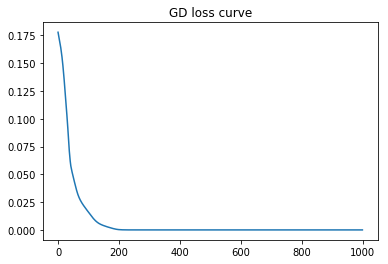

[0/1000] 0.5851414203643799
[500/1000] 0.4785999655723572


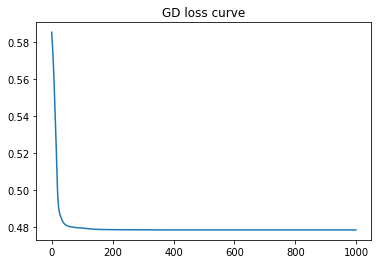

[0/1000] 0.5130327343940735
[500/1000] 0.45722347497940063


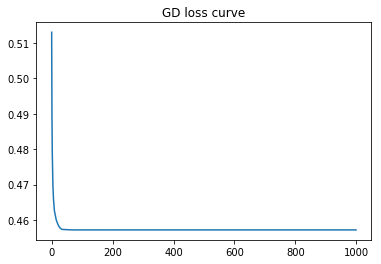

[0/1000] 0.4776930809020996
[500/1000] 0.43019601702690125


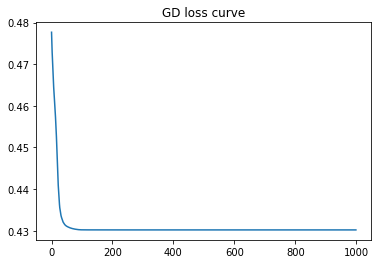

[0/1000] 0.4142545163631439
[500/1000] 0.3927472233772278


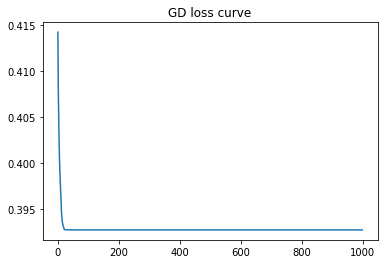

[0/1000] 0.6122283339500427
[500/1000] 0.6080617308616638


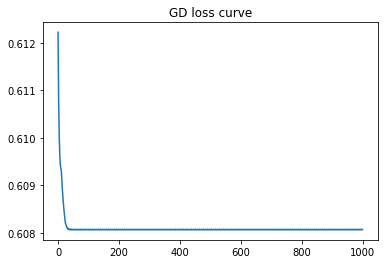

[0/1000] 0.838416576385498
[500/1000] 0.3264271914958954


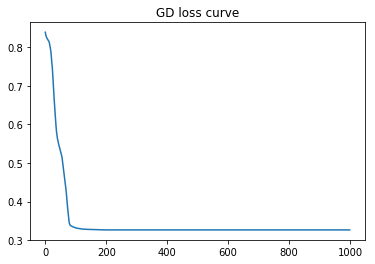

[0/1000] 0.4731515049934387
[500/1000] 0.4572766423225403


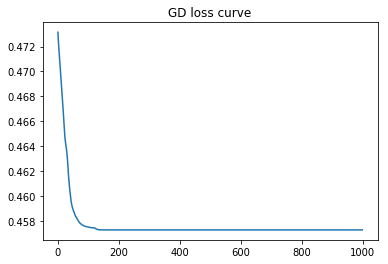

In [215]:
index = range(1)
l_min = np.inf
# Randomly sample initial points for 20 times
for i in range(20):
    u_0 = Variable(Tensor(np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))), requires_grad=True)
    u_hat, U, l = GD(y=y, u_0=u_0, index=index, epoch=1000)
    if l < l_min:
        u_hat_best = u_hat
        U_best = U
        l_min = l

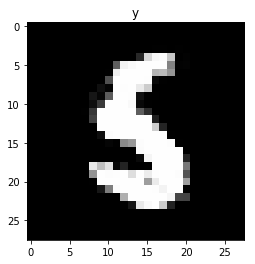

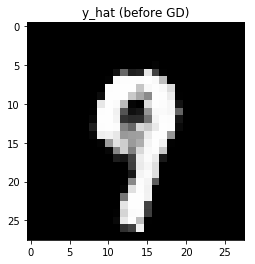

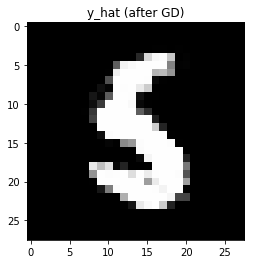

In [216]:
u_hat = u_hat_best
U = U_best
# Visualization of y_hat and y
vis(y[index, :, :, :], nrow=7, title='y')

with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0[index, :, :, :], nrow=7, title='y_hat (before GD)')
vis(y_hat[index, :, :, :], nrow=7, title='y_hat (after GD)')

**Noise model $y=G(u)+\eta$**

We have prior $u\sim\mathcal(m,I)$ and noise model $\eta\sim\mathcal(0,a\cdot I)$. Using Andrew's notations we will have:
$$\min_uJ(u)=\frac{1}{2}\|G(u)-y\|_{a\cdot I}^2+\frac{1}{2}\|u-m\|_{I}^2=\frac{1}{2a}\|G(u)-y\|_2^2+\frac{1}{2}\|u-m\|_2^2$$
$$u_{k+1}=u_k-\alpha_kDJ(u)$$

In [320]:
a = 0.5
eta = Variable(Tensor(np.random.normal(0, np.sqrt(a), (opt.gd_size, *opt.img_shape)))) # noise (we need sqrt)
m = Tensor(np.zeros((opt.gd_size, opt.latent_dim)))
with torch.no_grad():
    y = generator(u_gt) + eta # generated y from u_gt
    y_gt = generator(u_gt)

torch.Size([21, 2])
torch.Size([21, 1, 28, 28])


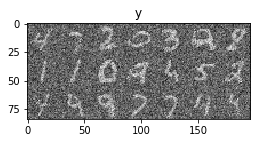

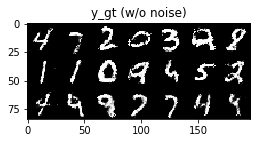

In [321]:
# Visualization of u_gt and y
print(u_gt.shape)
print(y.shape)
vis(y, nrow=7, title='y')
vis(y_gt, nrow=7, title='y_gt (w/o noise)')

[0/2000] 1.259515404701233
[500/2000] 0.977243185043335
[1000/2000] 0.9772389531135559
[1500/2000] 0.977247416973114


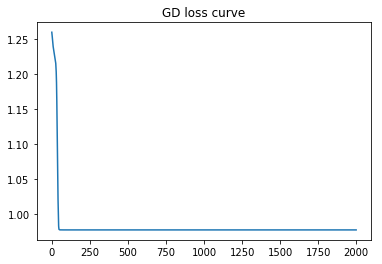

In [322]:
index = range(1)
u_0 = Variable(Tensor(np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))), requires_grad=True)
u_hat, U, l = GD(y=y, u_0=u_0, index=index, epoch=2000, noise=True, a=a, m=m)

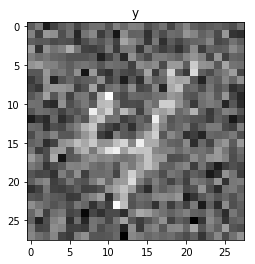

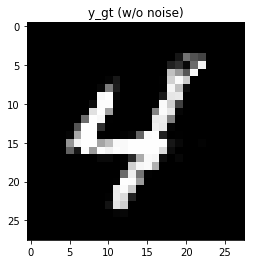

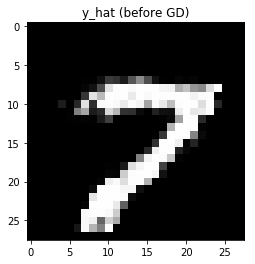

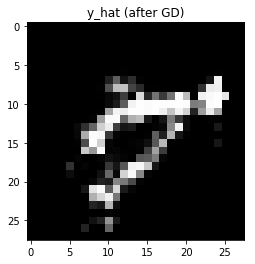

In [323]:
# Visualization of y_hat and y
vis(y[index, :, :, :], nrow=7, title='y')
vis(y_gt[index, :, :, :], nrow=7, title='y_gt (w/o noise)')
with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0[index, :, :, :], nrow=7, title='y_hat (before GD)')
vis(y_hat[index, :, :, :], nrow=7, title='y_hat (after GD)')

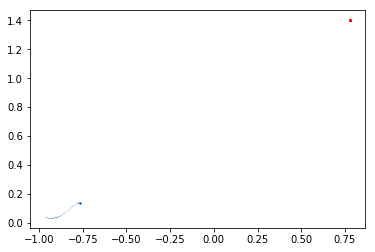

In [324]:
index = 0
plt.scatter(U[:, index, 0], U[:, index, 1], s=0.01)
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

In [325]:
u1, u2, Loss = heatmap(y=y, m=m, u1_min=-1.2, u1_max=0.9, u2_min=-0.2, u2_max=1.6, index=index, noise=True, a=a)

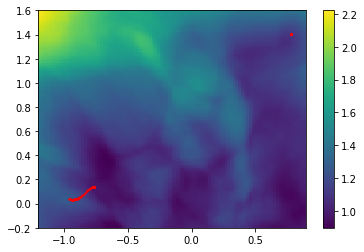

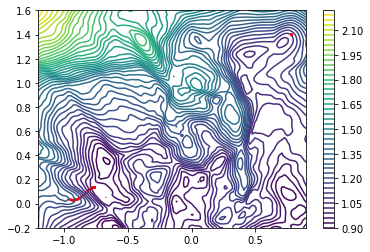

In [326]:
plt.pcolor(u1, u2, Loss)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

plt.contour(u1, u2, Loss, 50)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

**$L_1$ loss**
$$\min_uJ(u)=\frac{1}{2}\|G(u)-y\|_1$$
$$u_{k+1}=u_k-\alpha_kDJ(u)$$

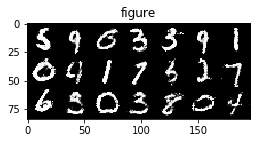

In [287]:
with torch.no_grad():
    y = generator(u_gt) # generated y from u_gt
vis(y, nrow=7)

In [288]:
def loss(a, b):
    return torch.norm(a-b, 1)

[0/10000] 4897.478515625
[500/10000] 3918.7275390625
[1000/10000] 3918.2021484375
[1500/10000] 3918.160888671875
[2000/10000] 3918.16357421875
[2500/10000] 3918.20751953125
[3000/10000] 3918.16162109375
[3500/10000] 3918.10009765625
[4000/10000] 3918.232177734375
[4500/10000] 3918.22021484375
[5000/10000] 3918.203857421875
[5500/10000] 3918.126953125
[6000/10000] 3918.15966796875
[6500/10000] 3918.18359375
[7000/10000] 3918.159423828125
[7500/10000] 3918.196533203125
[8000/10000] 3918.195068359375
[8500/10000] 3918.1640625
[9000/10000] 3918.171875
[9500/10000] 3918.175048828125


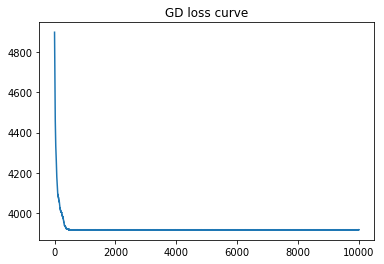

In [289]:
index = range(21)
u_hat, U, l = GD(y=y, u_0=u_0, lr=1e-5, loss=loss, index=index, epoch=10000, noise=False)

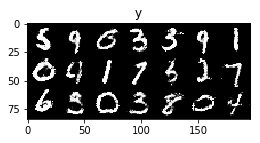

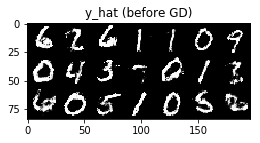

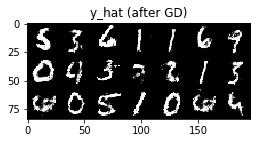

In [290]:
# Visualization of y_hat and y
vis(y[index, :, :, :], nrow=7, title='y')

with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0[index, :, :, :], nrow=7, title='y_hat (before GD)')
vis(y_hat[index, :, :, :], nrow=7, title='y_hat (after GD)')

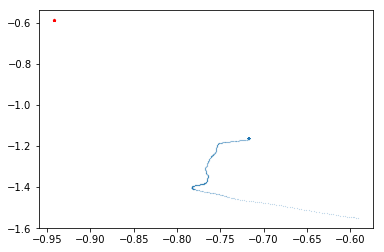

In [291]:
index = 5
plt.scatter(U[:, index, 0], U[:, index, 1], s=0.01)
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

In [292]:
u1, u2, Loss = heatmap(y=y, loss=loss, u1_min=-1.1, u1_max=-0.4, u2_min=-1.8, u2_max=-0.4, index=index, noise=False)

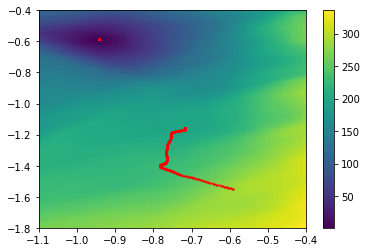

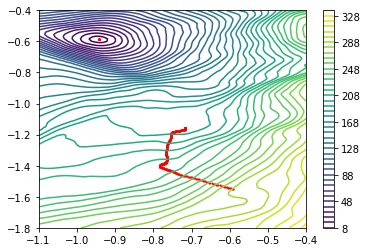

In [293]:
plt.pcolor(u1, u2, Loss)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

plt.contour(u1, u2, Loss, 50)
plt.colorbar()
plt.scatter(U[:, index, 0], U[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

**SGD & BGD**

In [25]:
u_gt = np.random.normal(0, 1, (1, opt.latent_dim)) # ground truth of u
with torch.no_grad():
    y = generator(Variable(Tensor(u_gt))) # ground truth of y = (u_gt)

n_measure = 5
u_gt_copy = Variable(Tensor(np.tile(u_gt, (n_measure, 1)))) # copies of ground truth u
a = 0.2 # variance of Gaussian noise
eta = Variable(Tensor(np.random.normal(0, a, (n_measure, *opt.img_shape)))) # noise
with torch.no_grad():
    y_copy = generator(u_gt_copy)
    y_noise = generator(u_gt_copy) + eta # noisy measurement of y from u_gt


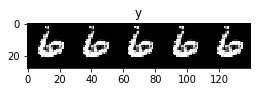

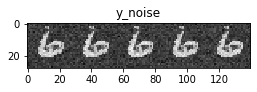

In [26]:
# Visualize y_noise and y
vis(y_copy,nrow=5,title='y')
vis(y_noise,nrow=5,title='y_noise')

[0/2000] tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)
[0/2000] tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)
[500/2000] tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)
[500/2000] tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)
[1000/2000] tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)
[1000/2000] tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)
[1500/2000] tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)
[1500/2000] tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


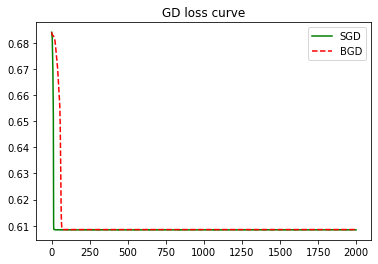

In [27]:
loss = nn.MSELoss()
m = Tensor(np.zeros((1, opt.latent_dim))) # for computing the regularizer
alpha = 5e-3 # learning rate
epoch = 2000
# initialization
u_hat1 = Variable(Tensor(np.random.normal(0, 0.2, (1, opt.latent_dim))), requires_grad=True)
u_hat2 = u_hat1
u_0 = u_hat1
n_measure = list(y_noise.shape)[0]
U_1= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_1[0, :, :] = u_0.detach().cpu().numpy()
U_2= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_2[0, :, :] = u_0.detach().cpu().numpy()
l1 = []
l2 = []
for i in range(epoch):
    # compute the objective function
    l1.append((loss(generator(u_hat1), y) + a*loss(u_hat1, m)).item())
    l2.append((loss(generator(u_hat2), y) + a*loss(u_hat2, m)).item())
    if i % 500 == 0:
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat1), y) + a*loss(u_hat1, m))
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat2), y) + a*loss(u_hat2, m))
    
    # stochastic gradient descent
    random_idx = np.random.permutation(n_measure)
    for j in range(n_measure):
        grad1 = autograd.grad(outputs=loss(generator(u_hat1), y_noise[random_idx[j],:,:,:]) + a*loss(u_hat1, m), inputs=u_hat1)[0]
        u_hat1 = u_hat1 - alpha * grad1
    # batch gradient descent
    grad2 = 0
    for j in range(n_measure):
        grad2 += autograd.grad(outputs=loss(generator(u_hat2), y_noise[j,:,:,:]) + a*loss(u_hat2, m), inputs=u_hat2)[0]
    u_hat2 = u_hat2 - alpha * grad2 / n_measure
    U_1[1+i, :, :] = u_hat1.detach().cpu().numpy()
    U_2[1+i, :, :] = u_hat2.detach().cpu().numpy()
x = np.arange(epoch)
plt.figure()
plt.plot(x, l1, 'g-', x, l2, 'r--')
plt.title('GD loss curve')
plt.legend(('SGD','BGD'))
plt.show()

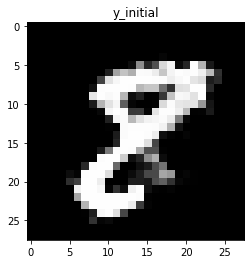

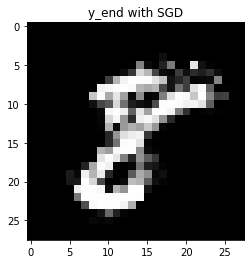

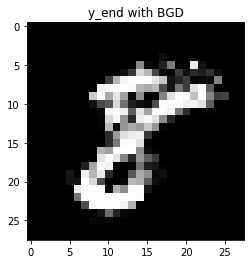

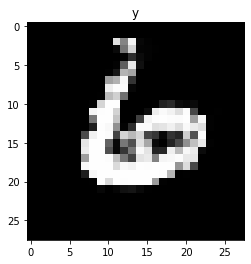

In [28]:
#Visualize y result
with torch.no_grad():
    y_0 = generator(Variable(Tensor(u_0)))
    y_hat1 = generator(Variable(Tensor(u_hat1)))
    y_hat2 = generator(Variable(Tensor(u_hat2)))
vis(y_0,nrow=5,title='y_initial')
vis(y_hat1,nrow=5,title='y_end with SGD')
vis(y_hat2,nrow=5,title='y_end with BGD')
vis(y,nrow=5,title='y')

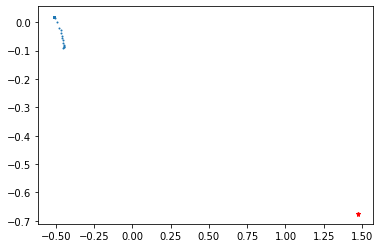

In [29]:
#Visuslize flow 
index = 0
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1)
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=5, color="red")
plt.show()

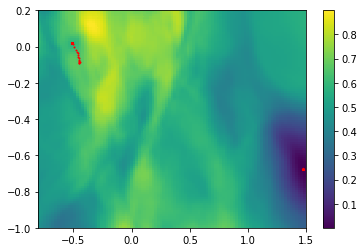

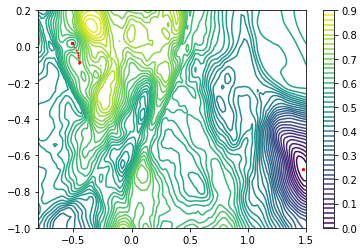

In [30]:
#Visuslize heatmap
u1, u2, Loss = heatmap(y=y, loss=loss, u1_min=-0.8, u1_max=1.5, u2_min=-1, u2_max=0.2, index=index, noise=False)
plt.pcolor(u1, u2, Loss)
plt.colorbar()
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

plt.contour(u1, u2, Loss, 50)
plt.colorbar()
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

**SGD & BGD**

With latent space 10 dim now


In [56]:
opt.latent_dim=10
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
opt.generator_path='G_l10_woBN.pth'
opt.discriminator_path='D_l10_woBN.pth'
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))
u_gt = np.random.normal(0, 1, (1, opt.latent_dim)) # ground truth of u
with torch.no_grad():
    y = generator(Variable(Tensor(u_gt))) # ground truth of y = (u_gt)

n_measure = 5
u_gt_copy = Variable(Tensor(np.tile(u_gt, (n_measure, 1)))) # copies of ground truth u
a = 0.2 # variance of Gaussian noise
eta = Variable(Tensor(np.random.normal(0, a, (n_measure, *opt.img_shape)))) # noise
with torch.no_grad():
    y_copy = generator(u_gt_copy)
    y_noise = generator(u_gt_copy) + eta # noisy measurement of y from u_gt


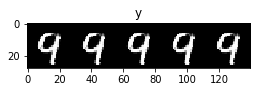

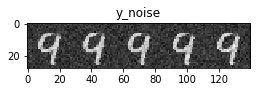

In [57]:
# Visualize y_noise and y
vis(y_copy,nrow=5,title='y')
vis(y_noise,nrow=5,title='y_noise')

[0/5000] tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)
[0/5000] tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)
[500/5000] tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)
[500/5000] tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)
[1000/5000] tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
[1000/5000] tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)
[1500/5000] tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
[1500/5000] tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)
[2000/5000] tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
[2000/5000] tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)
[2500/5000] tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
[2500/5000] tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)
[3000/5000] tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
[3000/5000] tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)
[3500/5000] tensor(0.0294, device='cuda:0', grad_fn=<Add

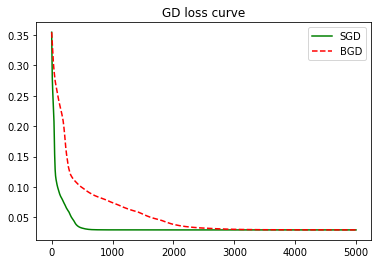

In [58]:
loss = nn.MSELoss()
m = Tensor(np.zeros((1, opt.latent_dim))) # for computing the regularizer
alpha = 5e-3 # learning rate
epoch = 5000
# initialization
u_hat1 = Variable(Tensor(np.random.normal(0, 0.2, (1, opt.latent_dim))), requires_grad=True)
u_hat2 = u_hat1
u_0 = u_hat1
n_measure = list(y_noise.shape)[0]
U_1= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_1[0, :, :] = u_0.detach().cpu().numpy()
U_2= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_2[0, :, :] = u_0.detach().cpu().numpy()
l1 = []
l2 = []
for i in range(epoch):
    # compute the objective function
    l1.append((loss(generator(u_hat1), y) + a*loss(u_hat1, m)).item())
    l2.append((loss(generator(u_hat2), y) + a*loss(u_hat2, m)).item())
    if i % 500 == 0:
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat1), y) + a*loss(u_hat1, m))
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat2), y) + a*loss(u_hat2, m))
    
    # stochastic gradient descent
    random_idx = np.random.permutation(n_measure)
    for j in range(n_measure):
        grad1 = autograd.grad(outputs=loss(generator(u_hat1), y_noise[random_idx[j],:,:,:]) + a*loss(u_hat1, m), inputs=u_hat1)[0]
        u_hat1 = u_hat1 - alpha * grad1
    # batch gradient descent
    grad2 = 0
    for j in range(n_measure):
        grad2 += autograd.grad(outputs=loss(generator(u_hat2), y_noise[j,:,:,:]) + a*loss(u_hat2, m), inputs=u_hat2)[0]
    u_hat2 = u_hat2 - alpha * grad2 / n_measure
    U_1[1+i, :, :] = u_hat1.detach().cpu().numpy()
    U_2[1+i, :, :] = u_hat2.detach().cpu().numpy()
x = np.arange(epoch)
plt.figure()
plt.plot(x, l1, 'g-', x, l2, 'r--')
plt.title('GD loss curve')
plt.legend(('SGD','BGD'))
plt.show()

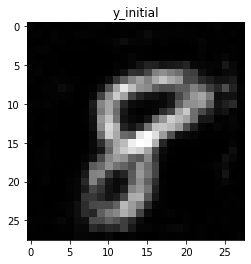

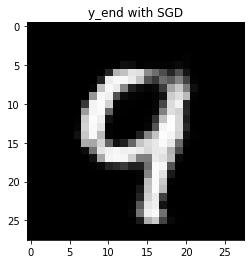

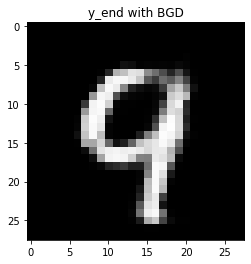

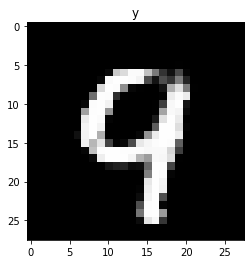

In [59]:
#Visualize y result
with torch.no_grad():
    y_0 = generator(Variable(Tensor(u_0)))
    y_hat1 = generator(Variable(Tensor(u_hat1)))
    y_hat2 = generator(Variable(Tensor(u_hat2)))
vis(y_0,nrow=5,title='y_initial')
vis(y_hat1,nrow=5,title='y_end with SGD')
vis(y_hat2,nrow=5,title='y_end with BGD')
vis(y,nrow=5,title='y')

**SGD & BGD**

With continuity LeakyReLU or Tanh

Previous LeakyReLU, Tanh for now

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Tanh())
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
# Initialize generator and discriminator
opt.latent_dim=2
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [63]:
opt.generator_path='G_l2_woBN_tanh.pth'
opt.discriminator_path='D_l2_woBN_tanh.pth'
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))

<All keys matched successfully>

In [64]:
u_gt = np.random.normal(0, 1, (1, opt.latent_dim)) # ground truth of u
with torch.no_grad():
    y = generator(Variable(Tensor(u_gt))) # ground truth of y = (u_gt)

n_measure = 5
u_gt_copy = Variable(Tensor(np.tile(u_gt, (n_measure, 1)))) # copies of ground truth u
a = 0.2 # variance of Gaussian noise
eta = Variable(Tensor(np.random.normal(0, a, (n_measure, *opt.img_shape)))) # noise
with torch.no_grad():
    y_copy = generator(u_gt_copy)
    y_noise = generator(u_gt_copy) + eta # noisy measurement of y from u_gt


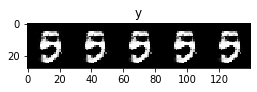

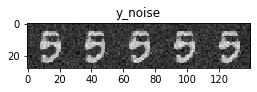

In [65]:
# Visualize y_noise and y
vis(y_copy,nrow=5,title='y')
vis(y_noise,nrow=5,title='y_noise')

[0/2000] tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)
[0/2000] tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)
[500/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
[500/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
[1000/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
[1000/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
[1500/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
[1500/2000] tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


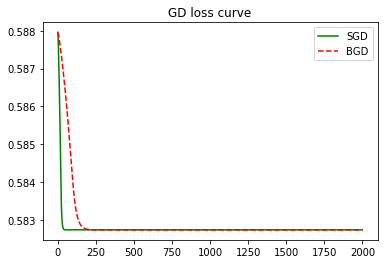

In [66]:
loss = nn.MSELoss()
m = Tensor(np.zeros((1, opt.latent_dim))) # for computing the regularizer
alpha = 5e-3 # learning rate
epoch = 2000
# initialization
u_hat1 = Variable(Tensor(np.random.normal(0, 0.2, (1, opt.latent_dim))), requires_grad=True)
u_hat2 = u_hat1
u_0 = u_hat1
n_measure = list(y_noise.shape)[0]
U_1= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_1[0, :, :] = u_0.detach().cpu().numpy()
U_2= np.zeros((epoch+1, opt.gd_size, opt.latent_dim))
U_2[0, :, :] = u_0.detach().cpu().numpy()
l1 = []
l2 = []
for i in range(epoch):
    # compute the objective function
    l1.append((loss(generator(u_hat1), y) + a*loss(u_hat1, m)).item())
    l2.append((loss(generator(u_hat2), y) + a*loss(u_hat2, m)).item())
    if i % 500 == 0:
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat1), y) + a*loss(u_hat1, m))
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat2), y) + a*loss(u_hat2, m))
    
    # stochastic gradient descent
    random_idx = np.random.permutation(n_measure)
    for j in range(n_measure):
        grad1 = autograd.grad(outputs=loss(generator(u_hat1), y_noise[random_idx[j],:,:,:]) + a*loss(u_hat1, m), inputs=u_hat1)[0]
        u_hat1 = u_hat1 - alpha * grad1
    # batch gradient descent
    grad2 = 0
    for j in range(n_measure):
        grad2 += autograd.grad(outputs=loss(generator(u_hat2), y_noise[j,:,:,:]) + a*loss(u_hat2, m), inputs=u_hat2)[0]
    u_hat2 = u_hat2 - alpha * grad2 / n_measure
    U_1[1+i, :, :] = u_hat1.detach().cpu().numpy()
    U_2[1+i, :, :] = u_hat2.detach().cpu().numpy()
x = np.arange(epoch)
plt.figure()
plt.plot(x, l1, 'g-', x, l2, 'r--')
plt.title('GD loss curve')
plt.legend(('SGD','BGD'))
plt.show()

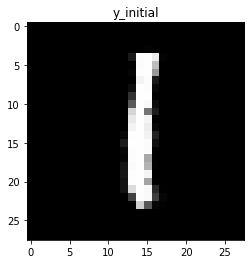

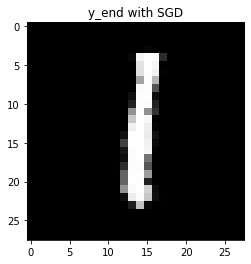

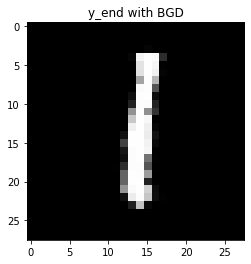

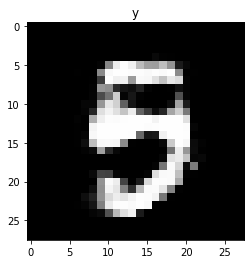

In [71]:
#Visualize y result
with torch.no_grad():
    y_0 = generator(Variable(Tensor(u_0)))
    y_hat1 = generator(Variable(Tensor(u_hat1)))
    y_hat2 = generator(Variable(Tensor(u_hat2)))
vis(y_0,nrow=5,title='y_initial')
vis(y_hat1,nrow=5,title='y_end with SGD')
vis(y_hat2,nrow=5,title='y_end with BGD')
vis(y,nrow=5,title='y')

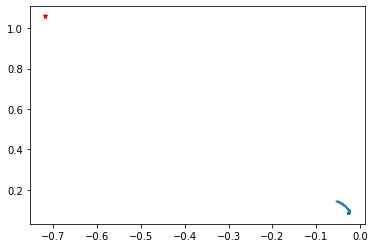

In [67]:
#Visuslize flow 
index = 0
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1)
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=5, color="red")
plt.show()

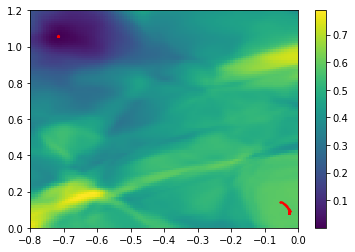

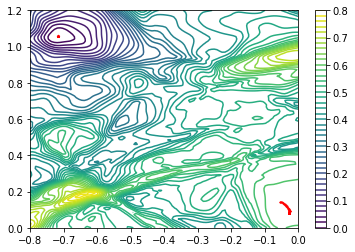

In [70]:
#Visuslize heatmap
u1, u2, Loss = heatmap(y=y, loss=loss, u1_min=-0.8, u1_max=0, u2_min=0, u2_max=1.2, index=index, noise=False)
plt.pcolor(u1, u2, Loss)
plt.colorbar()
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

plt.contour(u1, u2, Loss, 50)
plt.colorbar()
plt.scatter(U_1[:, index, 0], U_1[:, index, 1], s=1, color='red')
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()